In [2]:
from pathlib import Path

import torch
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

from scSLAT.model import spatial_match
from scSLAT.model import scanpy_workflow

In [ ]:
out_dir = Path("./confusion_matrix")
if not out_dir.exists():
    out_dir.mkdir()

In [ ]:
def plot_confusion(dataset:str, plot_histgram:bool=False, plot_confusing_matrix:bool=False):
    for method in ['SLAT_dpca', 'PASTE', 'STAGATE', 'Seurat', 'Harmony']:
        if 'visium'  in dataset:
            biology_meta = 'cell_type'
            topology_meta = 'layer_guess'
            matching =  np.loadtxt(f'../results/visium_human_DLPFC/cells:0/seed:0/{method}/matching.csv', dtype=int)
            adata1 = sc.read_h5ad('../results/visium_human_DLPFC/cells:0/seed:0/adata1.h5ad')
            adata2 = sc.read_h5ad('../results/visium_human_DLPFC/cells:0/seed:0/adata2.h5ad')
        elif 'merfish' in dataset:
            biology_meta = 'Cell_class'
            topology_meta = 'region'
            matching =  np.loadtxt(f'../results/merfish_mouse_hypothalamic/cells:0/seed:0/{method}/matching.csv', dtype=int)
            adata1 = sc.read_h5ad('../results/merfish_mouse_hypothalamic/cells:0/seed:0/adata1.h5ad')
            adata2 = sc.read_h5ad('../results/merfish_mouse_hypothalamic/cells:0/seed:0/adata2.h5ad')
        elif 'stereo'  in dataset:
            if method == 'PASTE':
                continue
            biology_meta = 'annotation'
            topology_meta = 'region'
            matching =  np.loadtxt(f'../results/stereo_mouse_embryo/cells:0/seed:0/{method}/matching.csv', dtype=int)
            adata1 = sc.read_h5ad('../results/stereo_mouse_embryo/cells:0/seed:0/adata1.h5ad')
            adata2 = sc.read_h5ad('../results/stereo_mouse_embryo/cells:0/seed:0/adata2.h5ad')
        
        if 'visium' in dataset:
            adata2.obs[biology_meta] = 'celltype_' + adata2.obs[biology_meta].astype('str')
            adata1.obs[biology_meta] = 'celltype_' + adata1.obs[biology_meta].astype('str')

        adata2.obs['target_celltype'] = adata1.obs.iloc[matching[1,:],:][biology_meta].to_list()
        adata2.obs['target_region'] = adata1.obs.iloc[matching[1,:],:][topology_meta].to_list()
        adata2.obs['target_celltype_region'] = adata2.obs['target_celltype'].astype('str') + '_' + adata2.obs['target_region'].astype('str')
        adata2.obs['celltype_region'] = adata2.obs[biology_meta].astype('str') + '_' + adata2.obs[topology_meta].astype('str')
        
        cross_table = adata2.obs.groupby(['celltype_region', 'target_celltype_region']).size()
        cross_table.to_csv(out_dir / f'{method}_{dataset}_cross_table.csv')
        
        if plot_histgram:
            cell_num = adata2.obs['celltype_region'].value_counts()
            cell_num_target = adata2.obs['target_celltype_region'].value_counts()
            
            # histogram of cell type column
            cell_num.plot.hist(bins=40, color='#607c8e')
            plt.title('Histogram of cell type')
            plt.xlabel('Cell numbers')
            plt.ylabel('Counts')
            plt.savefig(out_dir / f'{method}_{dataset}_celltype_histgram.png', dpi=300, bbox_inches='tight')
            
            cell_num_target.plot.hist(bins=40, color='#607c8e')
            plt.title('Histogram of target cell type')
            plt.xlabel('Cell numbers')
            plt.ylabel('Counts')
            plt.savefig(out_dir / f'{method}_{dataset}_target_celltype_histgram.png', dpi=300, bbox_inches='tight')
        
        if plot_confusing_matrix:
            celltype_label = adata2.obs[biology_meta].unique().tolist()
            region_label = adata2.obs[topology_meta].unique().tolist()
            # celltype_region_label = adata2.obs['celltype_region'].unique().tolist()
            
            # plt.figure(figsize=(len(celltype_region_label) * 0.7, len(celltype_region_label)  * 0.7))
            # cm = confusion_matrix(adata2.obs['celltype_region'], adata2.obs['target_celltype_region'], labels=celltype_region_label)
            # disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=celltype_region_label)
            # disp.plot(cmap='Reds', xticks_rotation='vertical', ax=plt.gca())
            # plt.savefig(out_dir / f'{dataset}_joint_confusing_matrix.png', dpi=300, bbox_inches='tight')

            # plt.figure(figsize=(len(celltype_label)  * 0.7, len(celltype_label)  * 0.7))
            # cm = confusion_matrix(adata2.obs[biology_meta], adata2.obs['target_celltype'], labels=celltype_label)
            # disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=celltype_label)
            # disp.plot(cmap='Reds', xticks_rotation='vertical', ax=plt.gca())
            # plt.savefig(out_dir / f'{method}_{dataset}_celltype_confusing_matrix.png', dpi=300, bbox_inches='tight')

            plt.figure(figsize=(len(region_label)  * 0.7, len(region_label)  * 0.7))
            cm = confusion_matrix(adata2.obs[topology_meta], adata2.obs['target_region'], labels=region_label)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=region_label)
            disp.plot(cmap='Reds', xticks_rotation='vertical', ax=plt.gca())
            plt.savefig(out_dir / f'{method}_{dataset}_region_confusing_matrix.png', dpi=300, bbox_inches='tight')


In [ ]:
plot_confusion('visium')
plot_confusion('merfish')
plot_confusion('stereo')

NameError: name 'plot_confusion' is not defined

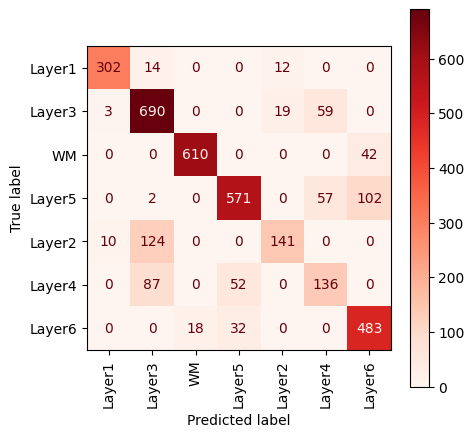

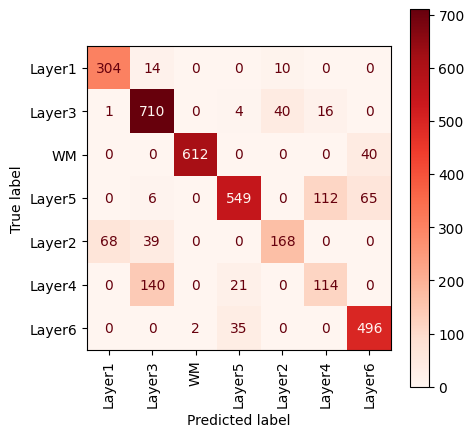

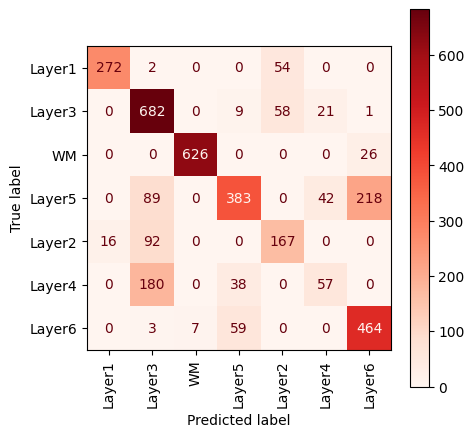

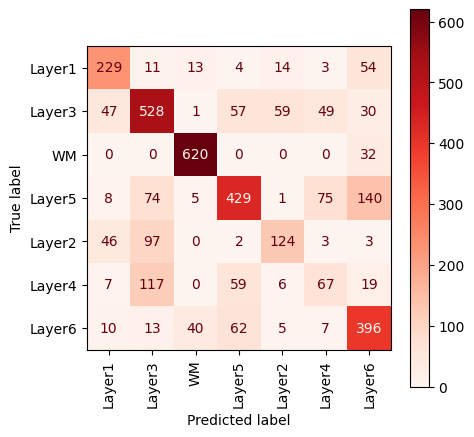

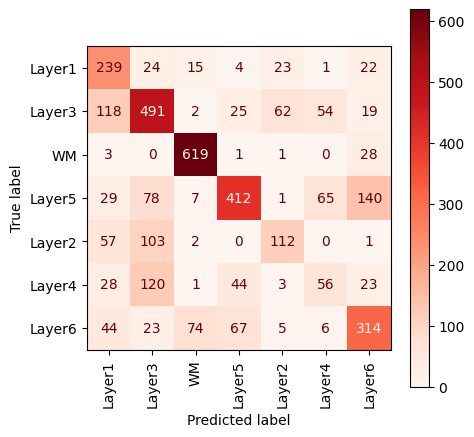

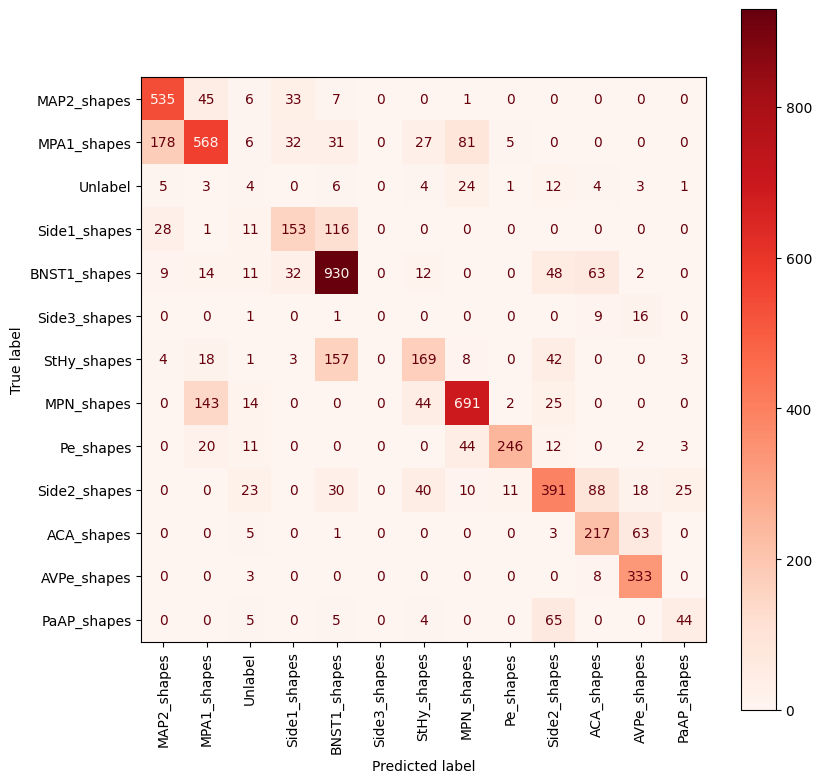

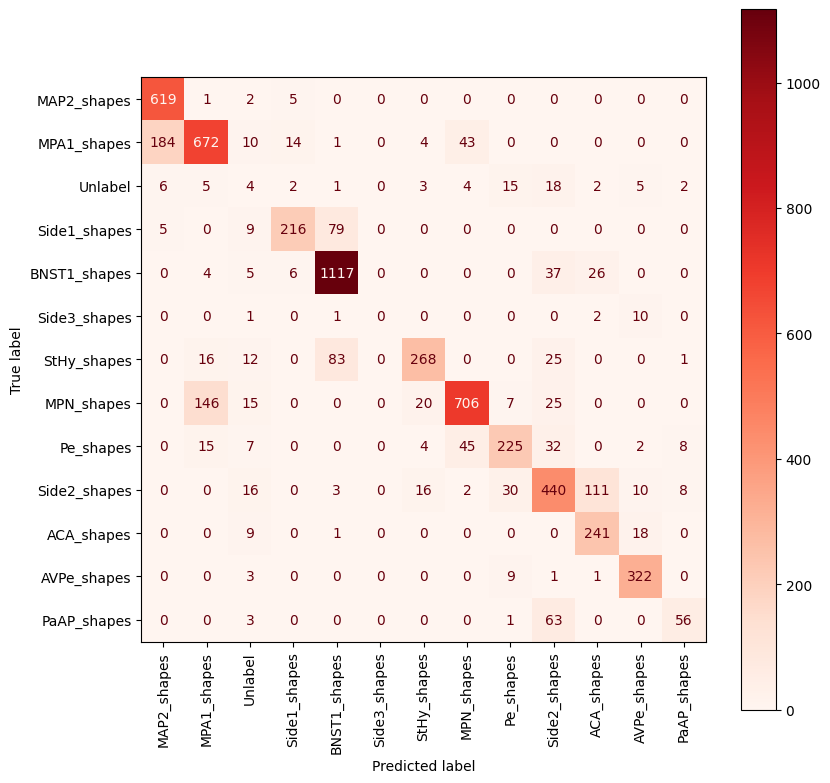

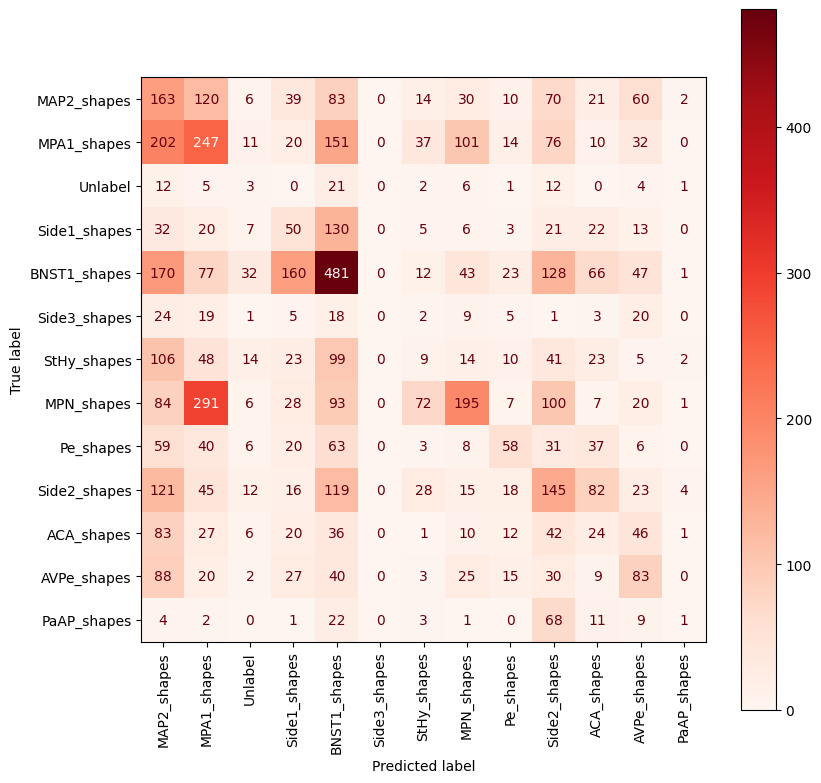

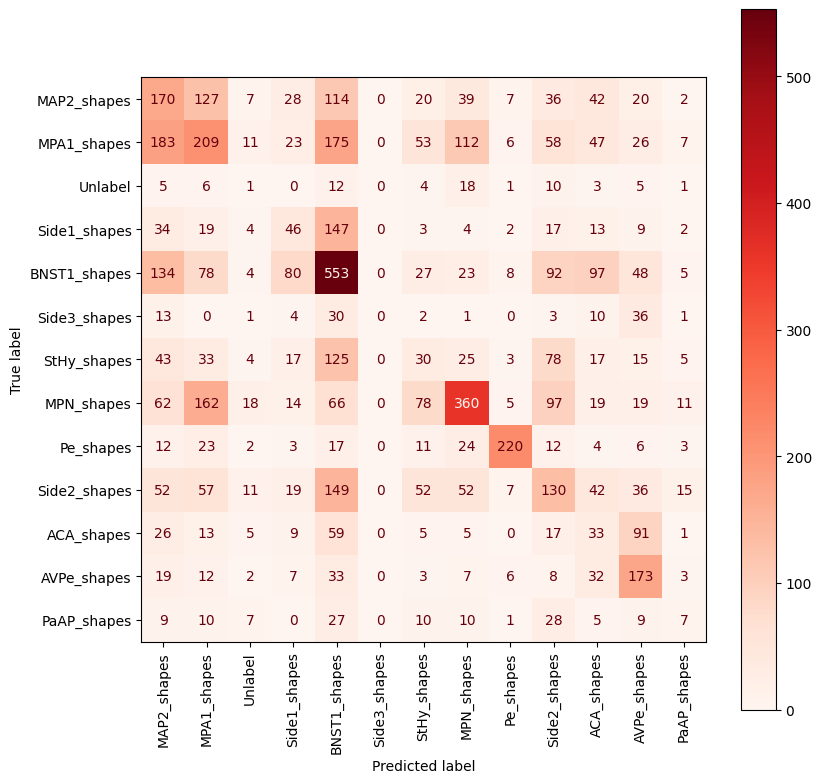

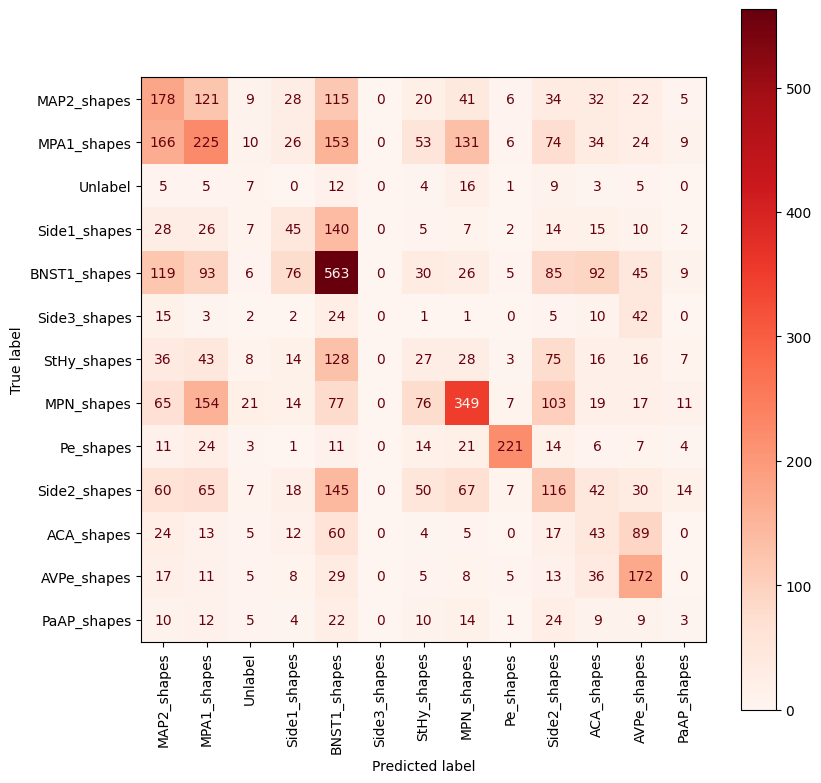

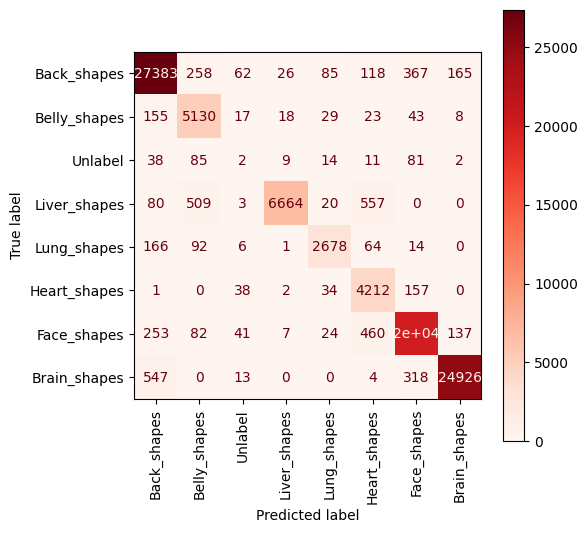

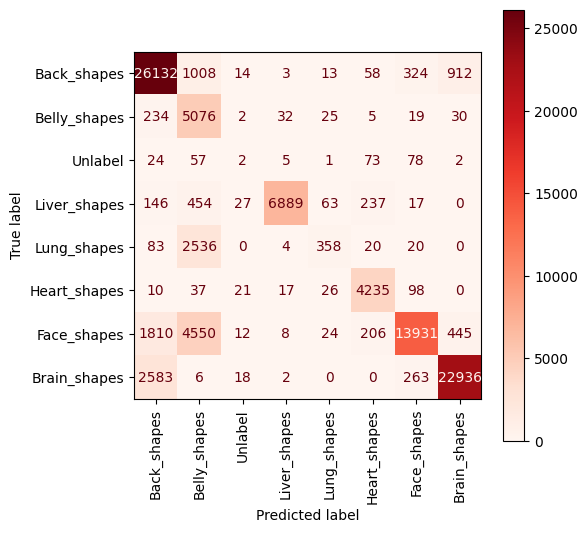

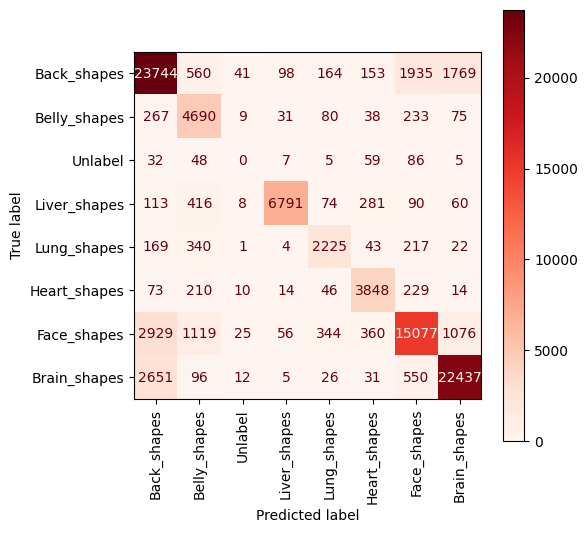

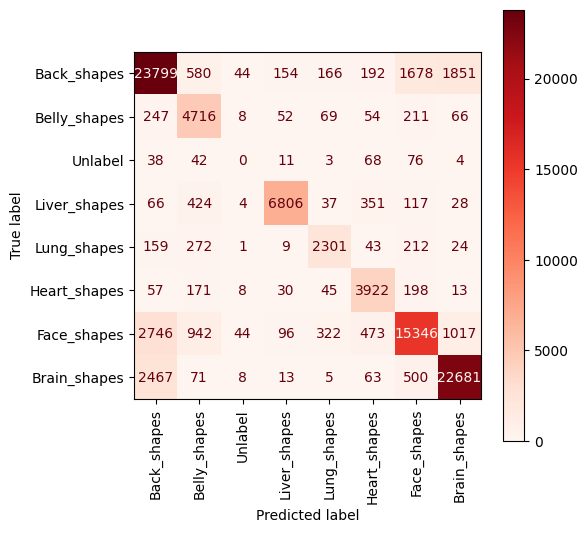

In [6]:
plot_confusion('visium', plot_confusing_matrix=True)
plot_confusion('merfish', plot_confusing_matrix=True)
plot_confusion('stereo', plot_confusing_matrix=True)

In [14]:
biology_meta = 'Cell_class'
topology_meta = 'region'

adata1 = sc.read_h5ad('../results/merfish_mouse_hypothalamic/cells:0/seed:0/adata1.h5ad')
adata2 = sc.read_h5ad('../results/merfish_mouse_hypothalamic/cells:0/seed:0/adata2.h5ad')
seurat_matching = np.loadtxt(f'../results/merfish_mouse_hypothalamic/cells:0/seed:0/Seurat/matching.csv', dtype=int)
slat_matching = np.loadtxt(f'../results/merfish_mouse_hypothalamic/cells:0/seed:0/SLAT_dpca/matching.csv', dtype=int)


In [ ]:
scanpy_workflow(adata2, viz=True)

In [15]:
adata2.obs['target_celltype_seurat'] = adata1.obs.iloc[seurat_matching[1,:],:][biology_meta].to_list()
adata2.obs['target_celltype_slat'] = adata1.obs.iloc[slat_matching[1,:],:][biology_meta].to_list()

In [47]:
adata2.obs['E_to_I'] = 'Unlabel'

In [48]:
adata2.obs.loc[(adata2.obs[biology_meta] == 'Excitatory') &
               ((adata2.obs['target_celltype_seurat'] ==  'Inhibitory') &
                ~(adata2.obs['target_celltype_slat'] == 'Inhibitory'))
               , 'E_to_I'] = 'Seurat_error'

adata2.obs.loc[(adata2.obs[biology_meta] == 'Excitatory') &
               (~(adata2.obs['target_celltype_seurat'] ==  'Inhibitory') &
                (adata2.obs['target_celltype_slat'] == 'Inhibitory'))
               , 'E_to_I'] = 'SLAT_error'

adata2.obs.loc[(adata2.obs[biology_meta] == 'Excitatory') &
               ((adata2.obs['target_celltype_seurat'] ==  'Inhibitory') &
                (adata2.obs['target_celltype_slat'] == 'Inhibitory'))
               , 'E_to_I'] = 'Both_error'


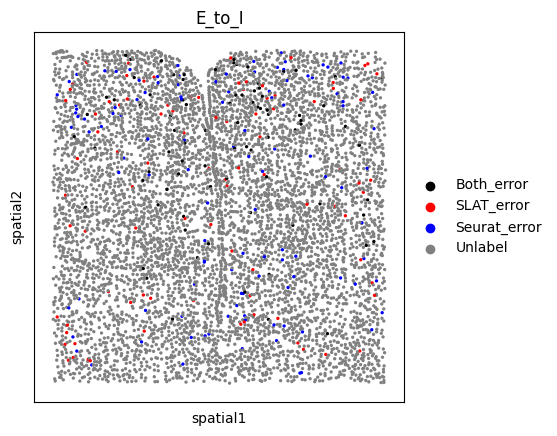

In [49]:
sc.pl.spatial(adata2, color='E_to_I', spot_size=10, palette=['Black', 'Red', 'Blue', 'Gray'])

/flash/grp/gglab/xiacr/SLAT-dev/conda/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


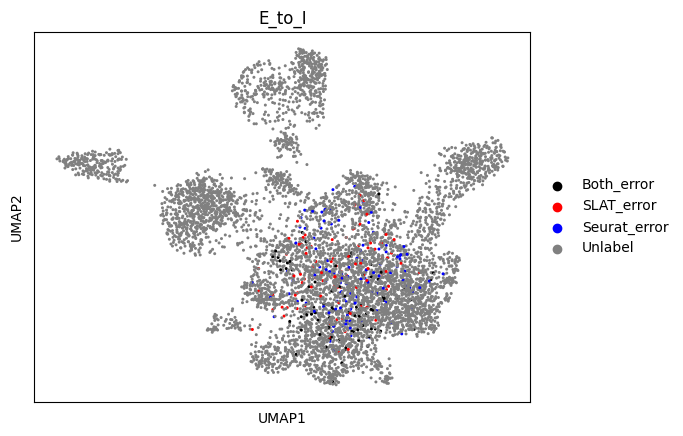

/flash/grp/gglab/xiacr/SLAT-dev/conda/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


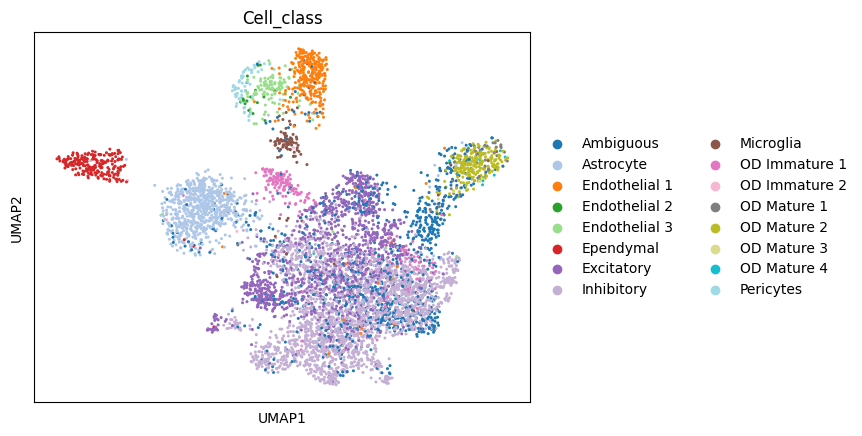

In [57]:
sc.pl.umap(adata2, color=['E_to_I'], palette=['Black', 'Red', 'Blue', 'Gray'])
sc.pl.umap(adata2, color='Cell_class', palette='tab20')

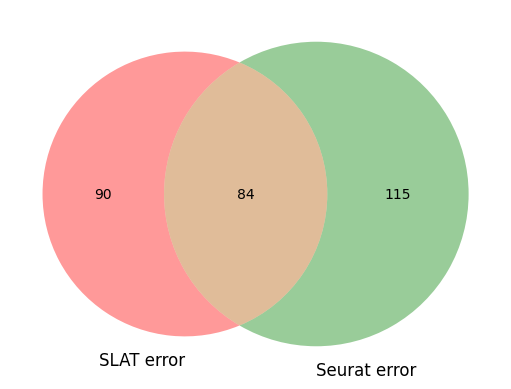

In [51]:
venn2(subsets = (90, 115, 84), set_labels = ('SLAT error', 'Seurat error'))
plt.show()